In [108]:
import sys
import torch
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

sys.path.insert(0, '../')
from lib.constants import *
from src.models import TransitionPredictor
from src.train import apply_masks, prelu1, reparameterize_fade

from scipy.signal import firwin, lfilter
from scipy.interpolate import interp1d

In [109]:
# import sys
# import torch
# import numpy as np
# import librosa
# import soundfile as sf
# import matplotlib.pyplot as plt

# sys.path.insert(0, '../')
# from lib.constants import *
# from src.models import TransitionPredictor, TransitionPredictorNoVolume
# from src.train import apply_masks, prelu1, apply_masks_no_volume

# from scipy.signal import firwin, lfilter
# from scipy.interpolate import interp1d

In [110]:
# Load saved tensors and phases
input_tensor, S_truth_tensor, phases, audios = torch.load('../data/preprocessed/sample_0.pt',
                                                  weights_only=False)

S1_phase = torch.tensor(phases['S1_phase'])
S2_phase = torch.tensor(phases['S2_phase'])
S_truth_phase = torch.tensor(phases['S_truth_phase'])

S1_audio = torch.tensor(audios['S1_audio'])
S2_audio = torch.tensor(audios['S2_audio'])
S_truth_audio = torch.tensor(audios['S_truth_audio'])

In [111]:
# Load your trained model
model = TransitionPredictor()

# Load the model state_dict from the checkpoint
checkpoint_path = '../checkpoints/mel_lr1e-5_L1_bounding_final.pth'
model.load_state_dict(torch.load(checkpoint_path))

# Set the model to evaluation mode
model.eval()

/var/folders/xg/wxxgtfvn18xd3w1f4y2cffkw0000gn/T/ipykernel_46429/2958051900.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_p

TransitionPredictor(
  (conv_layers): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=16, bias=True)
  )
)

In [112]:
# # Load your trained model
# model = TransitionPredictorNoVolume()

# # Load the model state_dict from the checkpoint
# checkpoint_path = '../checkpoints/mel_lr1e-5_novolume_final.pth'
# model.load_state_dict(torch.load(checkpoint_path))

# # Set the model to evaluation mode
# model.eval()

In [113]:
# Use the model to predict control signals for the transition
with torch.no_grad():
    control_signals = model(input_tensor.unsqueeze(0))

# Apply control signals to create the predicted mel-spectrogram using apply_masks
S1 = input_tensor[0]
S2 = input_tensor[1]
S_pred = apply_masks(S1, S2, control_signals[0], n_mels=S1.shape[0])

In [114]:
# # Use the model to predict control signals for the transition
# with torch.no_grad():
#     control_signals = model(input_tensor.unsqueeze(0))

# # Apply control signals to create the predicted mel-spectrogram using apply_masks
# S1 = input_tensor[0]
# S2 = input_tensor[1]
# S_pred = apply_masks_no_volume(S1, S2, control_signals[0], n_mels=S1.shape[0])

In [115]:
## WITHOUT PHASE ##

# # Convert S_pred to numpy array
# predicted_mel = S_pred.squeeze().detach().numpy()

# # Exponentiate the predicted mel-spectrogram since it was logged
# predicted_mel = np.exp(predicted_mel)

# # Reconstruct the audio using the Griffin-Lim algorithm
# reconstructed_audio = librosa.feature.inverse.mel_to_audio(predicted_mel, sr=SAMPLING_RATE,
#                                                            n_fft=N_FFT, hop_length=HOP_LENGTH)

In [117]:
## WITH PHASE ##

# Convert S_pred to numpy array
predicted_mel = S_pred.squeeze().detach().numpy()

# Exponentiate the predicted mel-spectrogram since it was logged
predicted_mel = np.exp(predicted_mel)

# Convert mel-spectrogram to STFT magnitude
predicted_stft = librosa.feature.inverse.mel_to_stft(predicted_mel, sr=SAMPLING_RATE, n_fft=N_FFT)

# Estimate the phase by averaging the phases of S1 and S2
estimated_phase = (np.angle(S1_phase.numpy()) + np.angle(S2_phase.numpy())) / 2
# estimated_phase = np.angle(S_truth_phase.numpy())

# Combine magnitude with estimated phase
stft_matrix = predicted_stft * np.exp(1j * estimated_phase)

# Reconstruct the audio using the Griffin-Lim algorithm
reconstructed_audio = librosa.griffinlim(np.abs(stft_matrix), n_iter=32, hop_length=HOP_LENGTH, win_length=N_FFT)

# Save the reconstructed audio
sf.write('../predictions/mel_lr1e-5_L1_bounding_avg_phase.wav', reconstructed_audio, SAMPLING_RATE)

In [118]:
# ## ONLY RECONSTRUCT S1 ##

# # Convert S1 (a torch tensor) to a numpy array and exponentiate,
# # since S1 is in log scale.
# S1_mel = S1.squeeze().detach().numpy()
# S1_mel = np.exp(S1_mel)

# # Convert the mel-spectrogram to an STFT magnitude.
# # Ensure you use the same sampling rate and FFT parameters as during analysis.
# S1_stft_magnitude = librosa.feature.inverse.mel_to_stft(S1_mel, sr=SAMPLING_RATE, n_fft=N_FFT)

# # Use the phase information from S1.
# # Here we extract the phase from S1_phase (assumed to be a torch tensor).
# phase = S1_phase.numpy()

# # Combine the STFT magnitude with the phase to create a complex STFT.
# stft_matrix = S1_stft_magnitude * np.exp(1j * phase)

# # # Reconstruct the audio.
# # # You can use librosa's Griffin-Lim algorithm if you want an iterative phase reconstruction.
# # # However, if the phase is already accurate, you might consider using librosa.istft directly.
# # reconstructed_audio = librosa.griffinlim(np.abs(stft_matrix), n_iter=32, hop_length=HOP_LENGTH, win_length=N_FFT)

# # Alternatively, if the phase is perfect:
# reconstructed_audio = librosa.istft(stft_matrix, hop_length=HOP_LENGTH, win_length=N_FFT)

# # Save the reconstructed audio
# sf.write('only_S1.wav', reconstructed_audio, SAMPLING_RATE)

In [119]:
# ## NO ESTIMATING ##

# # Load the audio file (using its original sampling rate)
# file_path = '../data/track/jwmtj61_00_12t6wktp.wav'
# audio, sr = librosa.load(file_path, sr=SAMPLING_RATE)

# # Compute the STFT of the audio
# stft_matrix = librosa.stft(audio, n_fft=N_FFT, hop_length=HOP_LENGTH)

# # Extract magnitude and phase directly from the STFT
# magnitude = np.abs(stft_matrix)
# phase = np.angle(stft_matrix)

# # Reconstruct the audio using the exact STFT
# # If the phase is accurate, librosa.istft should yield a nearly perfect reconstruction.
# reconstructed_audio = librosa.istft(stft_matrix, hop_length=HOP_LENGTH, win_length=N_FFT)

# # Save the reconstructed audio to verify by listening
# sf.write('no_estimating.wav', reconstructed_audio, SAMPLING_RATE)

# # Optionally, compute an error metric to compare original and reconstructed audio
# # mse = np.mean((audio - reconstructed_audio)**2)
# # print("Mean squared error between original and reconstructed audio:", mse)


In [120]:
### FOR BOUNDING ###

control_signals_ = control_signals.squeeze().detach().numpy()

raw_S1_vol_start, raw_S1_vol_slope, raw_S2_vol_start, raw_S2_vol_slope = control_signals_[:4]
    
# Unpack band parameters
band_control_signals = control_signals_[4:]
(raw_S1_low_start, raw_S1_low_slope,
    raw_S1_mid_start, raw_S1_mid_slope,
    raw_S1_high_start, raw_S1_high_slope,
    raw_S2_low_start, raw_S2_low_slope,
    raw_S2_mid_start, raw_S2_mid_slope,
    raw_S2_high_start, raw_S2_high_slope) = band_control_signals

# Define a time vector for plotting
frames = S1.shape[1]
time_vector = torch.arange(input_tensor.shape[-1], dtype=torch.float32, device=input_tensor.device)

def reparameterize_fade_numpy(raw_st, raw_delta, frames, epsilon=1e-6, beta=0.01):
    # Sigmoid function implementation
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    # Softplus function implementation
    def softplus(x):
        return np.log(1 + np.exp(x))
    
    # Reparameterize st to be in [0, frames]
    st = frames * sigmoid(raw_st)  # with proper initialization, sigmoid(0) = 0.5, so st starts at frames/2

    # Reparameterize delta using softplus and a scaling factor
    # Lower bound: 1/(Cout - st) ensures the fade doesn't fully complete too early.
    delta = beta * softplus(raw_delta) + (1.0 / (frames - st + epsilon))
    return st, delta

# Reparameterize fade
S1_vol_start, S1_vol_slope = reparameterize_fade_numpy(raw_S1_vol_start, raw_S1_vol_slope, frames)
S2_vol_start, S2_vol_slope = reparameterize_fade_numpy(raw_S2_vol_start, raw_S2_vol_slope, frames)

S1_low_start, S1_low_slope = reparameterize_fade_numpy(raw_S1_low_start, raw_S1_low_slope, frames)
S1_mid_start, S1_mid_slope = reparameterize_fade_numpy(raw_S1_mid_start, raw_S1_mid_slope, frames)
S1_high_start, S1_high_slope = reparameterize_fade_numpy(raw_S1_high_start, raw_S1_high_slope, frames)

S2_low_start, S2_low_slope = reparameterize_fade_numpy(raw_S2_low_start, raw_S2_low_slope, frames)
S2_mid_start, S2_mid_slope = reparameterize_fade_numpy(raw_S2_mid_start, raw_S2_mid_slope, frames)
S2_high_start, S2_high_slope = reparameterize_fade_numpy(raw_S2_high_start, raw_S2_high_slope, frames)

# Compute volume and band masks for S1 (fade-out)
S1_vol_mask = 1.0 - prelu1(time_vector, S1_vol_start, S1_vol_slope)
S1_low_mask = 1.0 - prelu1(time_vector, S1_low_start, S1_low_slope)
S1_mid_mask = 1.0 - prelu1(time_vector, S1_mid_start, S1_mid_slope)
S1_high_mask = 1.0 - prelu1(time_vector, S1_high_start, S1_high_slope)

# Compute S2 masks (fade-in)
S2_vol_mask = prelu1(time_vector, S2_vol_start, S2_vol_slope)
S2_low_mask = prelu1(time_vector, S2_low_start, S2_low_slope)
S2_mid_mask = prelu1(time_vector, S2_mid_start, S2_mid_slope)
S2_high_mask = prelu1(time_vector, S2_high_start, S2_high_slope)

In [121]:
# ### FOR REGULAR ###

# control_signals_ = control_signals.squeeze().detach().numpy()

# # Unpack volume parameters
# S1_vol_start, S1_vol_slope, S2_vol_start, S2_vol_slope = control_signals_[:4]

# # Unpack band parameters
# band_control_signals = control_signals_[4:]
# (S1_low_start, S1_low_slope,
#  S1_mid_start, S1_mid_slope,
#  S1_high_start, S1_high_slope,
#  S2_low_start, S2_low_slope,
#  S2_mid_start, S2_mid_slope,
#  S2_high_start, S2_high_slope) = band_control_signals

# # Define a time vector for plotting
# time_vector = torch.arange(input_tensor.shape[-1], dtype=torch.float32, device=input_tensor.device)

# # Compute volume and band masks for S1 (fade-out)
# S1_vol_mask = 1.0 - prelu1(time_vector, S1_vol_start, S1_vol_slope)
# S1_low_mask = 1.0 - prelu1(time_vector, S1_low_start, S1_low_slope)
# S1_mid_mask = 1.0 - prelu1(time_vector, S1_mid_start, S1_mid_slope)
# S1_high_mask = 1.0 - prelu1(time_vector, S1_high_start, S1_high_slope)

# # Compute S2 masks (fade-in)
# S2_vol_mask = prelu1(time_vector, S2_vol_start, S2_vol_slope)
# S2_low_mask = prelu1(time_vector, S2_low_start, S2_low_slope)
# S2_mid_mask = prelu1(time_vector, S2_mid_start, S2_mid_slope)
# S2_high_mask = prelu1(time_vector, S2_high_start, S2_high_slope)

In [122]:
# control_signals_ = control_signals.squeeze().detach().numpy()

# # Unpack band parameters
# band_control_signals = control_signals_
# (S1_low_start, S1_low_slope,
#  S1_mid_start, S1_mid_slope,
#  S1_high_start, S1_high_slope,
#  S2_low_start, S2_low_slope,
#  S2_mid_start, S2_mid_slope,
#  S2_high_start, S2_high_slope) = band_control_signals

# # Define a time vector for plotting
# time_vector = torch.arange(input_tensor.shape[-1], dtype=torch.float32, device=input_tensor.device)

# # Compute volume and band masks for S1 (fade-out)
# # S1_vol_mask = 1.0 - prelu1(time_vector, S1_vol_start, S1_vol_slope)
# S1_low_mask = 1.0 - prelu1(time_vector, S1_low_start, S1_low_slope)
# S1_mid_mask = 1.0 - prelu1(time_vector, S1_mid_start, S1_mid_slope)
# S1_high_mask = 1.0 - prelu1(time_vector, S1_high_start, S1_high_slope)

# # Compute S2 masks (fade-in)
# # S2_vol_mask = prelu1(time_vector, S2_vol_start, S2_vol_slope)
# S2_low_mask = prelu1(time_vector, S2_low_start, S2_low_slope)
# S2_mid_mask = prelu1(time_vector, S2_mid_start, S2_mid_slope)
# S2_high_mask = prelu1(time_vector, S2_high_start, S2_high_slope)

In [123]:
# Compute mel frequency boundaries
fmin = 0
fmax = SAMPLING_RATE / 2
mel_frequencies = librosa.mel_frequencies(n_mels=N_MELS, fmin=fmin, fmax=fmax)
lower_bound = mel_frequencies[42]
upper_bound = mel_frequencies[85]

print(f"Lower Bound: {lower_bound} Hz")
print(f"Upper Bound: {upper_bound} Hz")

Lower Bound: 1109.0801261491836 Hz
Upper Bound: 3544.3606937385 Hz


In [124]:
# Design FIR filters
def design_fir_filters():
    numtaps = 10001  # Number of filter coefficients (higher = sharper but more computationally expensive)
    
    # Low-pass filter (0 Hz to ~1109 Hz)
    fir_low = firwin(numtaps, cutoff=1109, fs=fmax*2, pass_zero='lowpass')
    
    # Band-pass filter (~1109 Hz to ~3544 Hz)
    fir_band = firwin(numtaps, cutoff=[1109, 3544], fs=fmax*2, pass_zero='bandpass')
    
    # High-pass filter (~3544 Hz to 11025 Hz)
    fir_high = firwin(numtaps, cutoff=3544, fs=fmax*2, pass_zero='highpass')
    
    return fir_low, fir_band, fir_high

def apply_fir_filters(audio, fir_low, fir_band, fir_high):
    audio_low = lfilter(fir_low, 1.0, audio)
    audio_mid = lfilter(fir_band, 1.0, audio)
    audio_high = lfilter(fir_high, 1.0, audio)
    return audio_low, audio_mid, audio_high

# Function to upsample masks
def upsample_mask(mask, target_length):
    """
    Upsample a mask to the target length using linear interpolation.

    Parameters:
        mask (numpy.ndarray): The original mask to be upsampled.
        target_length (int): The target length for the upsampled mask.

    Returns:
        numpy.ndarray: The upsampled mask.
    """
    orig_length = len(mask)
    x = np.linspace(0, orig_length - 1, num=orig_length)
    f = interp1d(x, mask, kind='linear', fill_value="extrapolate")
    x_new = np.linspace(0, orig_length - 1, num=target_length)
    return f(x_new)

In [125]:
# Design FIR filters
fir_low, fir_band, fir_high = design_fir_filters()

# Apply filters (splitting audio into sub bands)
S1_low, S1_mid, S1_high = apply_fir_filters(S1_audio, fir_low, fir_band, fir_high)
S2_low, S2_mid, S2_high = apply_fir_filters(S2_audio, fir_low, fir_band, fir_high)

# Upsample the masks for S1
S1_audio_length = len(S1_audio)
S1_low_env = upsample_mask(S1_low_mask.cpu().numpy(), S1_audio_length)
S1_mid_env = upsample_mask(S1_mid_mask.cpu().numpy(), S1_audio_length)
S1_high_env = upsample_mask(S1_high_mask.cpu().numpy(), S1_audio_length)
S1_vol_env = upsample_mask(S1_vol_mask.cpu().numpy(), S1_audio_length)

# Upsample the masks for S2
S2_audio_length = len(S2_audio)
S2_low_env = upsample_mask(S2_low_mask.cpu().numpy(), S2_audio_length)
S2_mid_env = upsample_mask(S2_mid_mask.cpu().numpy(), S2_audio_length)
S2_high_env = upsample_mask(S2_high_mask.cpu().numpy(), S2_audio_length)
S2_vol_env = upsample_mask(S2_vol_mask.cpu().numpy(), S2_audio_length)

In [126]:
# # Design FIR filters
# fir_low, fir_band, fir_high = design_fir_filters()

# # Apply filters (splitting audio into sub bands)
# S1_low, S1_mid, S1_high = apply_fir_filters(S1_audio, fir_low, fir_band, fir_high)
# S2_low, S2_mid, S2_high = apply_fir_filters(S2_audio, fir_low, fir_band, fir_high)

# # Upsample the masks for S1
# S1_audio_length = len(S1_audio)
# S1_low_env = upsample_mask(S1_low_mask.cpu().numpy(), S1_audio_length)
# S1_mid_env = upsample_mask(S1_mid_mask.cpu().numpy(), S1_audio_length)
# S1_high_env = upsample_mask(S1_high_mask.cpu().numpy(), S1_audio_length)

# # Upsample the masks for S2
# S2_audio_length = len(S2_audio)
# S2_low_env = upsample_mask(S2_low_mask.cpu().numpy(), S2_audio_length)
# S2_mid_env = upsample_mask(S2_mid_mask.cpu().numpy(), S2_audio_length)
# S2_high_env = upsample_mask(S2_high_mask.cpu().numpy(), S2_audio_length)


In [127]:
# Apply sub band envelopes and volume envelope
S1_low_processed  = S1_low * (S1_low_env * S1_vol_env)
S1_mid_processed  = S1_mid * (S1_mid_env * S1_vol_env)
S1_high_processed = S1_high * (S1_high_env * S1_vol_env)
S2_low_processed = S2_low * (S2_low_env * S2_vol_env)
S2_mid_processed = S2_mid * (S2_mid_env * S2_vol_env)
S2_high_processed = S2_high * (S2_high_env * S2_vol_env)

# Reconstruct audio
S1_processed = S1_low_processed + S1_mid_processed + S1_high_processed
S2_processed = S2_low_processed + S2_mid_processed + S2_high_processed

# Combine tracks
S_pred_audio = S1_processed + S2_processed

# Save the combined audio signal to a file
sf.write('../predictions/mel_lr1e-5_L1_bounding_filter.wav', S_pred_audio, SAMPLING_RATE)

In [49]:
# # # Apply sub band envelopes
# # S1_low_processed  = S1_low * S1_low_env
# # S1_mid_processed  = S1_mid * S1_mid_env
# # S1_high_processed = S1_high * S1_high_env
# # S2_low_processed = S2_low * S2_low_env
# # S2_mid_processed = S2_mid * S2_mid_env
# # S2_high_processed = S2_high * S2_high_env

# # Apply sub band envelopes and volume envelope
# S1_low_processed  = S1_low * (S1_low_env)
# S1_mid_processed  = S1_mid * (S1_mid_env)
# S1_high_processed = S1_high * (S1_high_env)
# S2_low_processed = S2_low * (S2_low_env)
# S2_mid_processed = S2_mid * (S2_mid_env)
# S2_high_processed = S2_high * (S2_high_env)

# # Reconstruct audio
# S1_processed = S1_low_processed + S1_mid_processed + S1_high_processed
# S2_processed = S2_low_processed + S2_mid_processed + S2_high_processed

# # # Apply volume envelope
# # S1_processed *=  S1_vol_env
# # S2_processed *= S2_vol_env

# # Combine tracks
# S_pred_audio = S1_processed + S2_processed

# # Save the combined audio signal to a file
# sf.write('../predictions/mel_lr1e-5_novolume_filter.wav', S_pred_audio, SAMPLING_RATE)

In [50]:
# sf.write('it_didnt_work.wav', S_truth_audio, SAMPLING_RATE)

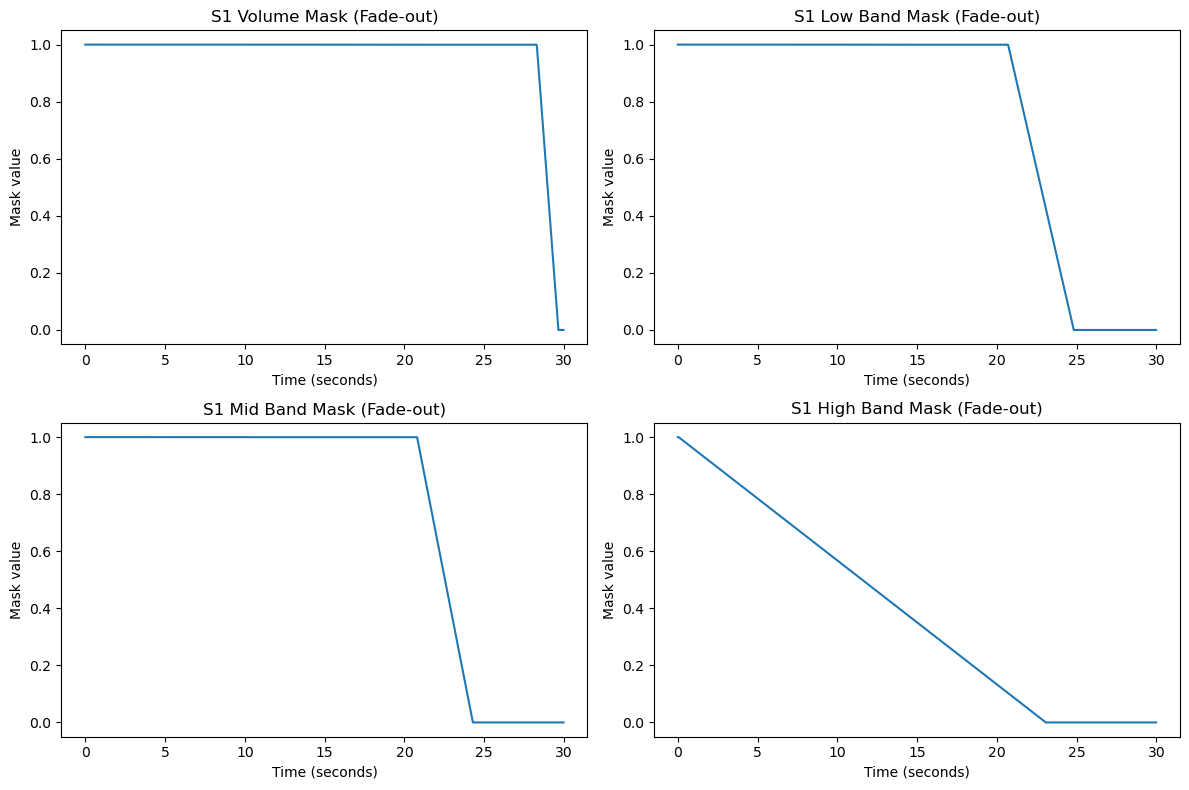

In [128]:
# Plot each mask over time
plt.figure(figsize=(12, 8))

# Generate a time vector that matches the length of the upsampled envelopes
time_vector_env = np.linspace(0, S1_audio_length / SAMPLING_RATE, num=S1_audio_length)

plt.subplot(2, 2, 1)
plt.plot(time_vector_env, S1_vol_env)
plt.title("S1 Volume Mask (Fade-out)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mask value")

plt.subplot(2, 2, 2)
plt.plot(time_vector_env, S1_low_env)
plt.title("S1 Low Band Mask (Fade-out)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mask value")

plt.subplot(2, 2, 3)
plt.plot(time_vector_env, S1_mid_env)
plt.title("S1 Mid Band Mask (Fade-out)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mask value")

plt.subplot(2, 2, 4)
plt.plot(time_vector_env, S1_high_env)
plt.title("S1 High Band Mask (Fade-out)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mask value")

plt.tight_layout()
plt.show()

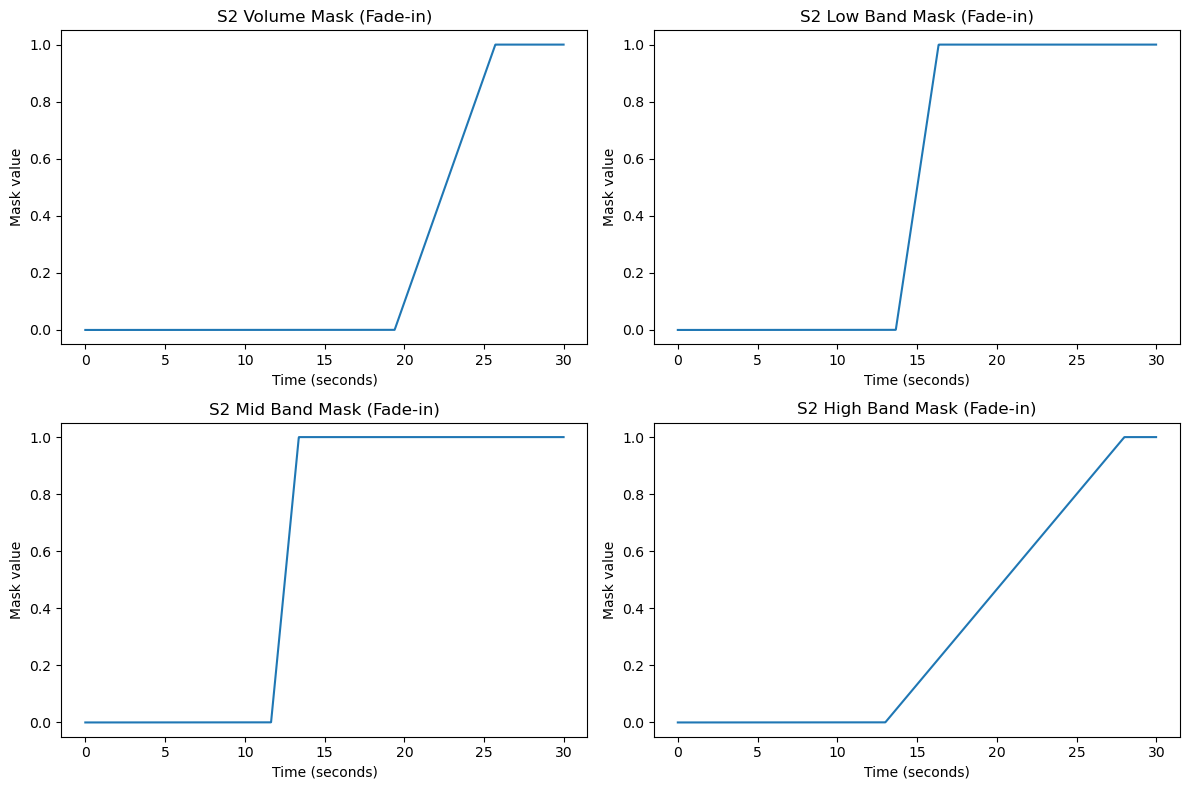

In [130]:
# Plot each mask over time
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(time_vector_env, S2_vol_env)
plt.title("S2 Volume Mask (Fade-in)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mask value")

plt.subplot(2, 2, 2)
plt.plot(time_vector_env, S2_low_env)
plt.title("S2 Low Band Mask (Fade-in)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mask value")

plt.subplot(2, 2, 3)
plt.plot(time_vector_env, S2_mid_env)
plt.title("S2 Mid Band Mask (Fade-in)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mask value")

plt.subplot(2, 2, 4)
plt.plot(time_vector_env, S2_high_env)
plt.title("S2 High Band Mask (Fade-in)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mask value")

plt.tight_layout()
plt.show()

In [54]:
# # Plot each mask over time
# plt.figure(figsize=(12, 8))

# plt.subplot(2, 2, 2)
# plt.plot(time_vector_env, S2_low_env)
# plt.title("S2 Low Band Mask (Fade-in)")
# plt.xlabel("Time (seconds)")
# plt.ylabel("Mask value")

# plt.subplot(2, 2, 3)
# plt.plot(time_vector_env, S2_mid_env)
# plt.title("S2 Mid Band Mask (Fade-in)")
# plt.xlabel("Time (seconds)")
# plt.ylabel("Mask value")

# plt.subplot(2, 2, 4)
# plt.plot(time_vector_env, S2_high_env)
# plt.title("S2 High Band Mask (Fade-in)")
# plt.xlabel("Time (seconds)")
# plt.ylabel("Mask value")

# plt.tight_layout()
# plt.show()

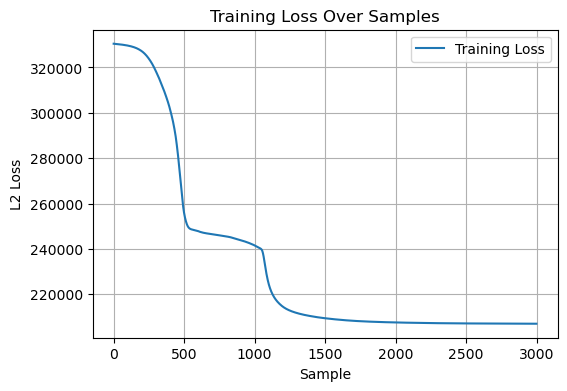

In [132]:
# Load the loss array from the .npy file
loss_array = np.load('../training_losses/mel_lr1e-5_L2_bounding_loss_array.npy')

# Create a plot of the loss array
plt.figure(figsize=(6, 4))
plt.plot(loss_array, label='Training Loss')
plt.xlabel('Sample')
plt.ylabel('L2 Loss')
plt.title('Training Loss Over Samples')
plt.legend()
plt.grid(True)
plt.show()